# 1. Setup

### Libraries

In [1]:
import sys
import os

# sys.path.append("../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4")
# sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
# sys.path.append("../input/segmentation-models-pytorch/segmentation_models.pytorch-master")

# sys.path.append("../input/segmentationmoodel030/efficientnet_pytorch-0.7.1/efficientnet_pytorch-0.7.1")
# sys.path.append("../input/segmentationmoodel030/segmentation_models_pytorch-0.3.0/segmentation_models_pytorch-0.3.0")

In [2]:
# # Making pretrained weights work without needing to find the default filename
# if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
#         os.makedirs('/root/.cache/torch/hub/checkpoints/')

# !cp '../input/efficientnet-pytorch-pretrained/efficientnet-b0-355c32eb.pth' '/root/.cache/torch/hub/checkpoints/'

In [3]:
# !pip install /kaggle/input/rsna-2023-whl-files/wheelhouse/python_gdcm-3.0.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install ../input/timm0412/timm-0.4.12-py3-none-any.whl
# !pip install ../input/pretrainedmodels-wheels/pretrainedmodels-0.7.4-py3-none-any.whl --no-index --find-links=../input/pretrainedmodels-wheels -q
# !pip install ../input/rsna-2023-whl-files/wheelhouse/efficientnet_pytorch-0.7.1-py3-none-any.whl --no-index --find-links=../input/rsna-2023-whl-files/wheelhouse -q
# !pip install ../input/rsna-2023-whl-files/wheelhouse/segmentation_models_pytorch-0.3.0-py3-none-any.whl --no-deps

In [4]:
import sys

# sys.path.append('../input/efficientnet/EfficientNet-PyTorch-master/')
# sys.path.append('../input/efficientnet/EfficientNet-PyTorch-master/efficientnet_pytorch')
from efficientnet_pytorch import EfficientNet
# sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import random
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.auto import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings

import copy
import zipfile
from scipy import ndimage
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from PIL import Image
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from skimage import exposure

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import nibabel as nib
import pydicom as dicom
import gc 
import segmentation_models_pytorch as smp


/home/junseonglee/miniconda3/envs/rsna_abtd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
class CFG:
    seed=42
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=8
    valid_bs=64
    fold_num=5 
    
    target_cols = ['bowel_healthy', 'bowel_injury', 'extravasation_healthy', \
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',\
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',\
       'spleen_low', 'spleen_high']    
    num_classes=5
    
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    fold_list=[0]

    model_arch="efficientnet-b0"         
    
    img_size=512     
    croped_img_size = 320 # 裁剪后的图片尺寸
    weight_path = f"./efficientnet-b0_109_fold0_epoch12.pth" 
    
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
#datadir = "./kaggle/input/rsna-2023-abdominal-trauma-detection"
datadir = '/home/junseonglee/Desktop/01_codes/inputs/rsna-2023-abdominal-trauma-detection'

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)

# def load_dicom(path):
#     """
#     This supports loading both regular and compressed JPEG images. 
#     See the first sell with `pip install` commands for the necessary dependencies
#     """
#     img = dicom.dcmread(path)
#     img.PhotometricInterpretation = 'YBR_FULL'
#     data = img.pixel_array
#     data = data - np.min(data)
#     if np.max(data) != 0:
#         data = data / np.max(data)
#     # data = (data * 255).astype(np.uint8)            
    
#     return data

# https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/435815
# test_images/3124/5842/514.dcm
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first cell with `pip install` commands for the necessary dependencies
    """
    try:
        img = dicom.dcmread(path)
        img.PhotometricInterpretation = 'YBR_FULL'
        data = img.pixel_array
        data = data - np.min(data)
        if np.max(data) != 0:
            data = data / np.max(data)

        return data
    except Exception as e:
        # # If the image is the known corrupt one, handle it specially.
        print(f"Error loading {path}: {e}")
        return np.zeros((CFG.img_size, CFG.img_size))  # Assuming a default size of 512x512, adjust if necessary


In [7]:
test_df = pd.read_csv(f'{datadir}/train_series_meta.csv')

debug = False
if len(test_df)==6:
    debug = True    
    
#     # Fix mismatch with test_images folder
#     test_df = pd.DataFrame(columns = ['row_id','series_id','aortic_hu'])
#     for i in ['1.2.826.0.1.3680043.22327','1.2.826.0.1.3680043.25399','1.2.826.0.1.3680043.5876']:
#         for j in ['C1','C2','C3','C4','C5','C6','C7','patient_overall']:
#             test_df = test_df.append({'row_id':i+'_'+j,'StudyInstanceUID':i,'prediction_type':j},ignore_index=True)
    
#     # Sample submission
#     ss = pd.DataFrame(test_df['row_id'])
#     ss['fractured'] = 0.5
#     print(test_df.shape)

In [8]:
test_df

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0
...,...,...,...,...
4706,9961,2003,381.00,0
4707,9961,63032,143.75,0
4708,9980,40214,103.00,0
4709,9980,40466,135.00,0


In [9]:
test_study_list = np.unique(test_df["series_id"].values).tolist()
test_study_list

[3,
 9,
 14,
 59,
 76,
 77,
 92,
 102,
 118,
 127,
 137,
 181,
 242,
 251,
 297,
 307,
 317,
 347,
 364,
 383,
 397,
 419,
 427,
 428,
 429,
 498,
 515,
 517,
 525,
 527,
 548,
 550,
 561,
 567,
 581,
 601,
 603,
 629,
 631,
 637,
 639,
 653,
 687,
 725,
 728,
 769,
 778,
 781,
 810,
 838,
 848,
 883,
 891,
 908,
 917,
 924,
 928,
 942,
 992,
 999,
 1005,
 1030,
 1053,
 1054,
 1061,
 1063,
 1071,
 1084,
 1092,
 1093,
 1117,
 1119,
 1124,
 1126,
 1133,
 1157,
 1201,
 1222,
 1232,
 1238,
 1252,
 1254,
 1274,
 1277,
 1320,
 1324,
 1342,
 1357,
 1368,
 1378,
 1383,
 1386,
 1407,
 1413,
 1416,
 1418,
 1429,
 1435,
 1478,
 1481,
 1487,
 1493,
 1504,
 1514,
 1525,
 1532,
 1554,
 1621,
 1628,
 1631,
 1636,
 1646,
 1656,
 1689,
 1715,
 1757,
 1780,
 1787,
 1788,
 1796,
 1802,
 1808,
 1825,
 1839,
 1843,
 1845,
 1849,
 1858,
 1872,
 1913,
 1941,
 1952,
 1970,
 1974,
 1988,
 1989,
 2003,
 2049,
 2082,
 2085,
 2111,
 2117,
 2154,
 2162,
 2165,
 2180,
 2185,
 2191,
 2204,
 2215,
 2216,
 2242,
 2260

In [10]:
import glob

all_slice_list = []
for file_name in test_study_list:
    image_path_list = glob.glob(f"{datadir}/train_images/*/{file_name}/*")
    image_path_list = sorted(image_path_list, key=lambda x:int(x.split("/")[-1].replace(".dcm","")))
    
    for path_idx in range(len(image_path_list)):
        path1 = "nofile" if path_idx-1 < 0 else image_path_list[path_idx-1].replace(f"{datadir}/test_images/", "")
        path2 = image_path_list[path_idx].replace(f"{datadir}/test_images/", "")
        path3 = "nofile" if path_idx+1 >= len(image_path_list) else image_path_list[path_idx+1].replace(f"{datadir}/test_images/", "")
        slice_num = int(path2.split("/")[-1].replace(".dcm",""))
        all_slice_list.append([f"{file_name}_{slice_num}", file_name, slice_num, path1, path2, path3])

In [11]:
slice_df = pd.DataFrame(all_slice_list, columns=["id", "series_id", "slice_num", "path1", "path2", "path3"])
slice_df

,id,series_id,slice_num,path1,path2,path3
0,3_196,3,196,nofile,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1,3_197,3,197,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
2,3_198,3,198,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
3,3_199,3,199,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4,3_200,3,200,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
...,...,...,...,...,...,...
1500648,65535_126,65535,126,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500649,65535_127,65535,127,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500650,65535_128,65535,128,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500651,65535_129,65535,129,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...


In [12]:
# ################# patient_id까지 출력하기. #################
# import glob
# import pandas as pd

# all_slice_list = []

# for file_name in test_study_list:
#     image_path_list = glob.glob(f"{datadir}/train_images/*/{file_name}/*")
#     image_path_list = sorted(image_path_list, key=lambda x: int(x.split("/")[-1].replace(".dcm", "")))

#     for path_idx in range(len(image_path_list)):
#         path1 = "nofile" if path_idx-1 < 0 else image_path_list[path_idx-1].replace(f"{datadir}/test_images/", "")
#         path2 = image_path_list[path_idx].replace(f"{datadir}/test_images/", "")
#         path3 = "nofile" if path_idx+1 >= len(image_path_list) else image_path_list[path_idx+1].replace(f"{datadir}/test_images/", "")
        
#         slice_num = int(path2.split("/")[-1].replace(".dcm", ""))
#         # Extracting patient_id from path2
#         patient_id = path2.split("/")[-3]
        
#         all_slice_list.append([f"{file_name}_{slice_num}", file_name, slice_num, patient_id, path1, path2, path3])

# # Modified column names to include "patient_id"
# slice_df = pd.DataFrame(all_slice_list, columns=["id", "series_id", "slice_num", "patient_id", "path1", "path2", "path3"])
# slice_df


# DataSet

In [13]:
class VoxelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        im2 = load_dicom(f"{row['path2']}")   # 512*512                  
        im2h = im2.shape[0]
        im2w = im2.shape[1]

        im1 = load_dicom(f"{row['path1']}") if row['path1'] != "nofile" else np.zeros((im2h, im2w))  # 512*512                                                       
        im3 = load_dicom(f"{row['path3']}") if row['path3'] != "nofile" else np.zeros((im2h, im2w))  # 512*512  

        if im1.shape != (im2h, im2w):
            im1 = cv2.resize(im1, (im2w, im2h))
        if im3.shape != (im2h, im2w):
            im3 = cv2.resize(im3, (im2w, im2h)) 
        image_list = [im1, im2, im3]
        image = np.stack(image_list, axis=2)  # 512*512*3; 0-1

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # print(row)
        # print(row['path2'])
        # print(row['series_id'])
        
        # image = image/255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # 3*img_size*img_size; 0-1
        return torch.from_numpy(image), row['series_id'], row['slice_num']

In [14]:
from albumentations import CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform, Compose
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

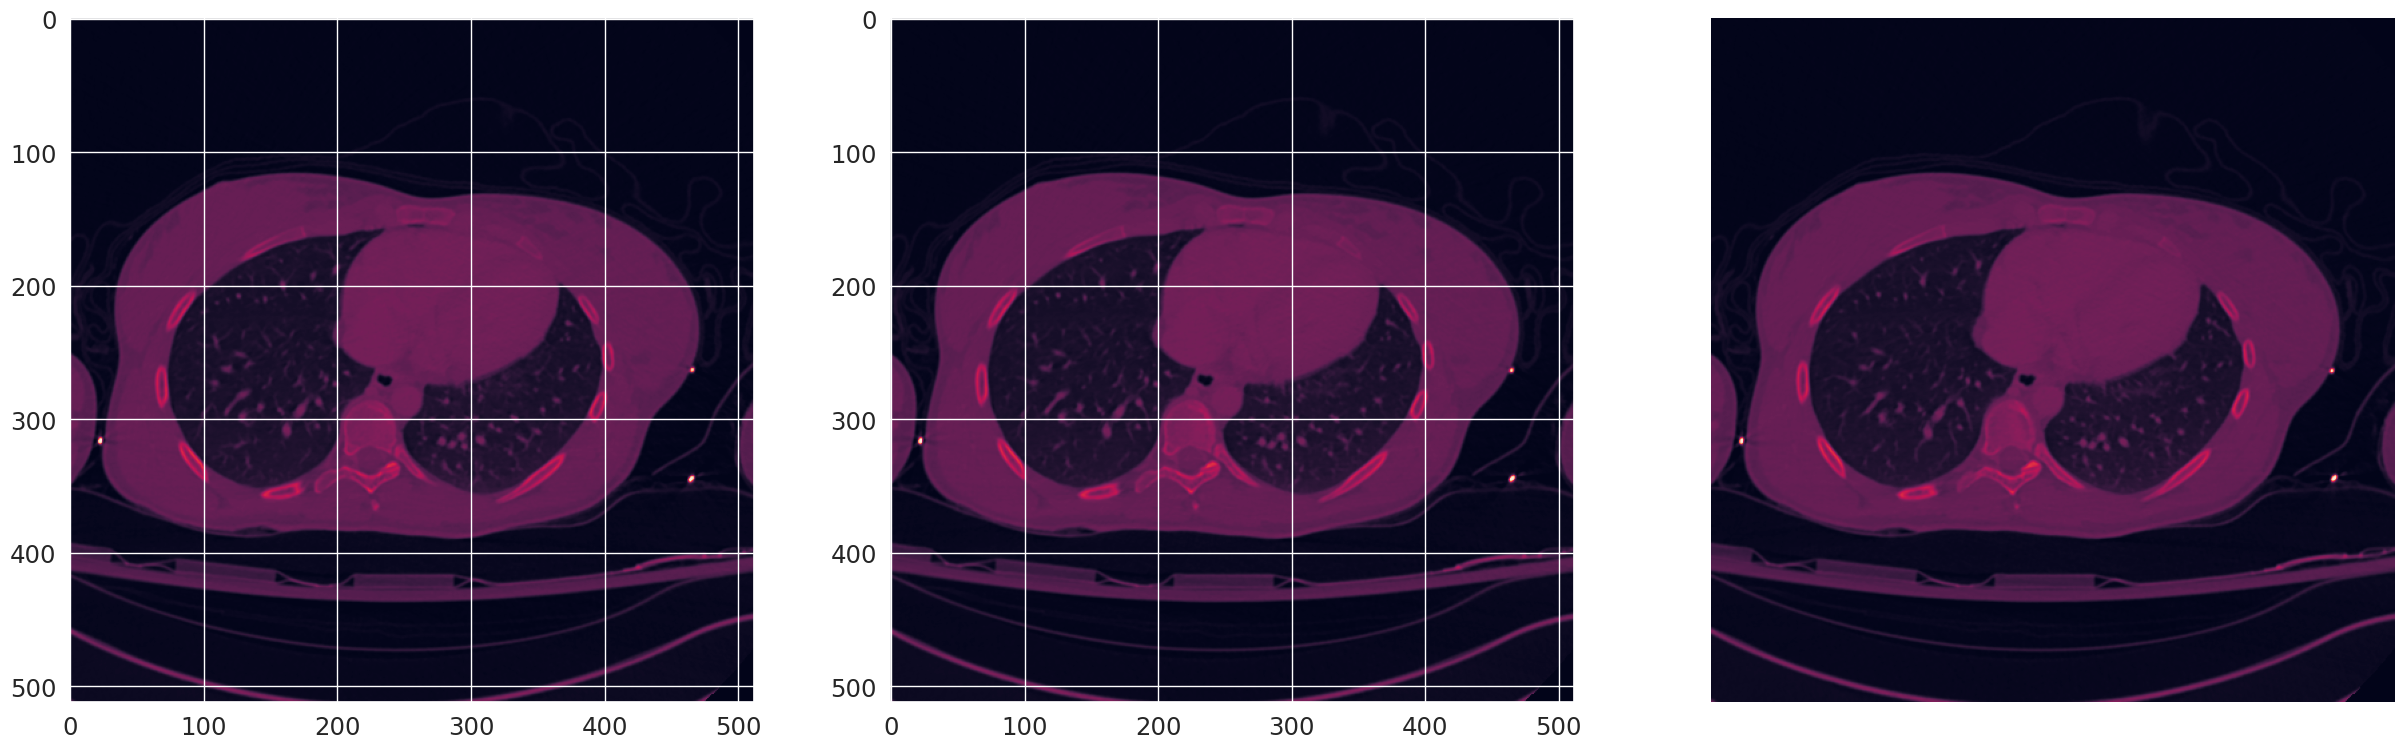

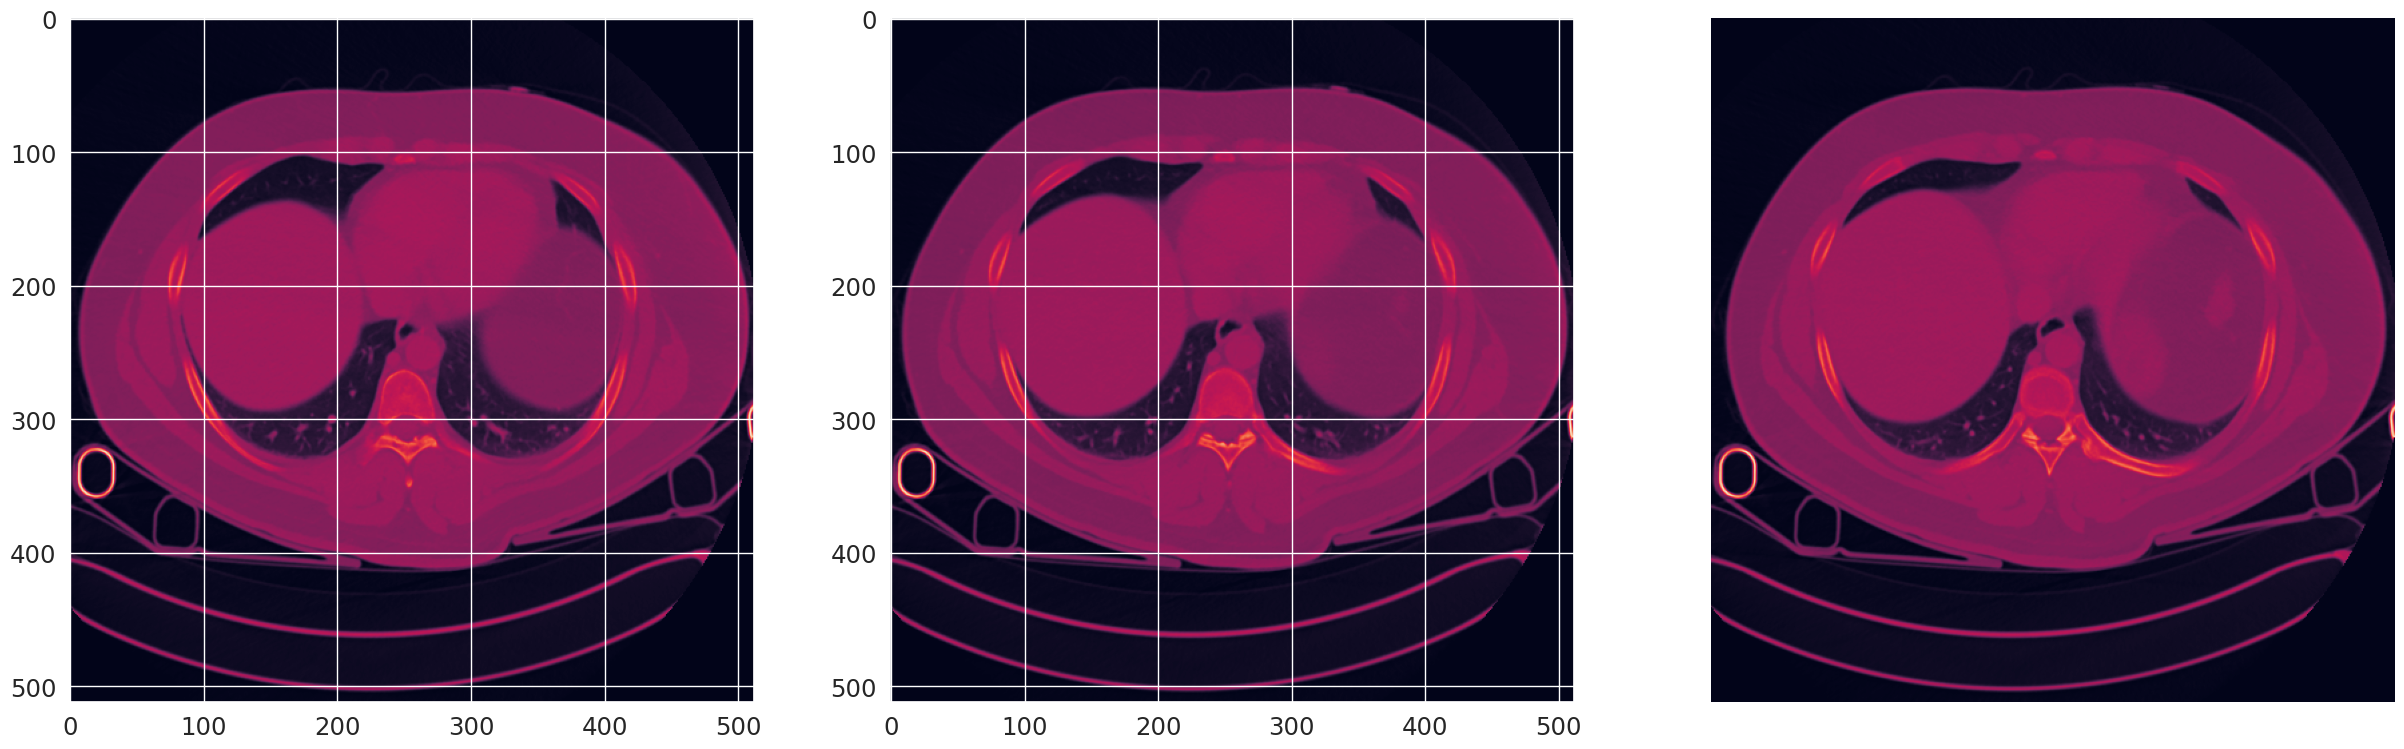

In [15]:
debug=True
if debug:
    from pylab import rcParams
    dataset_show = VoxelDataset(
        slice_df, 
        get_transforms("valid") # None, get_transforms("train")
        )
    rcParams['figure.figsize'] = 30,20
    for i in range(2):
        f, axarr = plt.subplots(1,3)
        idx = np.random.randint(0, len(dataset_show))
        img, file_name, n_slice= dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[0].imshow(img[0]); plt.axis('OFF');
        axarr[1].imshow(img[1]); plt.axis('OFF');
        axarr[2].imshow(img[2]); plt.axis('OFF');

# Model

In [16]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    #model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

In [45]:

slice_class_list = []
voxel_crop_list = []
def crop_voxel(voxel_mask, last_f_name):
    area_thr = 10
    # x
    x_list = []
    length = voxel_mask.shape[0]

    for i in range(length):
        #if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
        if torch.sum(voxel_mask[i]>0) >=area_thr:
            x_list.append(i)
            for i in range(length-1, -1, -1):
                if torch.sum(voxel_mask[i]>0) >= area_thr:
                    x_list.append(i)
                    break
            break
    else:
        x_list.append(0)
        x_list.append(length-1)



    #else:
    #    x_list.append(length-1)

    # y
    y_list = []
    length = voxel_mask.shape[1]

    for i in range(length):
        #if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
        if torch.sum(voxel_mask[:,i]>0) >=area_thr:
            y_list.append(i)
            for i in range(length-1, -1, -1):
                if torch.sum(voxel_mask[:,i]>0) >= area_thr:
                    y_list.append(i)
                    break
            break
    else:
        y_list.append(0)
        y_list.append(length-1)


    # z
    z_list = []
    length = voxel_mask.shape[2]
    
    for i in range(length):
        #if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
        if torch.sum(voxel_mask[:,:,i]>0) >=area_thr:
            z_list.append(i)
            for i in range(length-1, -1, -1):
                if torch.sum(voxel_mask[:,:,i]>0) >= area_thr:
                    z_list.append(i)
                    break
            break
    else:
        z_list.append(0)
        z_list.append(length-1)
    # croped_voxel = voxels[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    try:
        croped_voxel_mask = voxel_mask[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    except:
        print(f"last_f_name:{last_f_name}, voxel_mask.shape:{voxel_mask.shape}, x_list:{x_list}, y_list:{y_list}, z_list:{z_list}")
        x_list = [0, voxel_mask.shape[0]-1]; y_list = [0, voxel_mask.shape[1]-1]; z_list = [0, voxel_mask.shape[2]-1]
        croped_voxel_mask = voxel_mask
    voxel_crop_list.append([last_f_name, voxel_mask.shape[1], x_list[0], x_list[1]+1, y_list[0], y_list[1]+1, z_list[0], z_list[1]+1])

    # croped_voxel = croped_voxel.to('cpu').numpy() # bs*img_size*img_size; 0-5 classes
    croped_voxel_mask = croped_voxel_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-5 classes
    for x_idx in range(croped_voxel_mask.shape[0]):
        slice_mask = croped_voxel_mask[x_idx]

        unique, counts = np.unique(slice_mask, return_counts=True)
        if len(unique) == 1 and unique[0] == 0:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0], 0])
        elif unique[0] == 0:
            unique = unique[1:]
            counts = counts[1:]
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        else:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        
    return None, croped_voxel_mask

In [48]:
test_dataset = VoxelDataset(slice_df, transform=get_transforms("valid")) # get_transforms("valid")
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

model = load_model(CFG.weight_path)
model.eval()
last_f_name = ""

# voxels = []

In [41]:
slice_df

,id,series_id,slice_num,path1,path2,path3
0,3_196,3,196,nofile,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1,3_197,3,197,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
2,3_198,3,198,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
3,3_199,3,199,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4,3_200,3,200,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
...,...,...,...,...,...,...
1500648,65535_126,65535,126,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500649,65535_127,65535,127,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500650,65535_128,65535,128,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1500651,65535_129,65535,129,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...


In [42]:
# 1. slice_df에서 카운트가 1인 series_id를 찾습니다.
unique_series_ids = slice_df['series_id'].value_counts()
single_ids = unique_series_ids[unique_series_ids == 1].index.tolist()

In [43]:
single_ids

[]

In [51]:
voxel_mask = []

for step, (images, file_names, n_slice) in tqdm(enumerate(test_loader),total=len(test_loader)):
    images = images.to(device, dtype=torch.float) # bs*3*image_size*image_size
    batch_size = images.size(0)
    with torch.no_grad():
        y_pred = model(images) # [B, 8, H, W]
    y_pred = y_pred.sigmoid()
    slice_mask_max = torch.max(y_pred, 1) # bs*img_size*img_size
    slice_mask = torch.where((slice_mask_max.values)>0.5, slice_mask_max.indices+1, 0) # bs*img_size*img_size; 0-8 classes
    slice_mask = torch.where(slice_mask==5,0,slice_mask).type(torch.uint8)
    # slice_mask = slice_mask.to('cplu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    # slice_image = images[:, 1, :, :] # bs*img_size*img_size

    start_idx = 0
    ind_range = np.linspace(0, batch_size-1, CFG.num_workers, dtype =int)

    for bs_idx in range(batch_size):
        f_name = file_names[bs_idx]
        
        # 2. 카운트가 1인 series_id에 대한 예외처리
        if f_name in single_ids:
            single_mask = slice_mask[bs_idx].unsqueeze(0)  # Add batch dimension
            croped_voxel, croped_voxel_mask = crop_voxel(single_mask, f_name)
            continue
                
        
        if f_name != last_f_name:            
            voxel_mask.append(slice_mask[start_idx:bs_idx])
            # voxels.append(slice_image[start_idx:bs_idx])
            voxel_mask = torch.cat(voxel_mask, dim=0).to(device) # n_slice*img_size*img_size; 0-8 classes
            # voxels = torch.cat(voxels, dim=0) # n_slice*img_size*img_size
            if len(voxel_mask) > 0:
                croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)
            last_f_name = f_name
            start_idx = bs_idx
            voxel_mask = []
            # voxels = []
        
        #if f_name !=last_f_name:
        #    continue
        #마지막에 voxel_
        elif bs_idx == batch_size-1:
        #else:
            voxel_mask.append(slice_mask[start_idx:batch_size])
        # voxels.append(slice_image[start_idx:batch_size])


if voxel_mask:
    voxel_mask = torch.cat(voxel_mask, dim=0).to(device)
if len(voxel_mask) > 0:
    croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)

  3%|▎         | 634/23448 [03:06<1:51:56,  3.40it/s]


KeyboardInterrupt: 

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
!nvidia-smi

In [ ]:
sadfasdfadsfasf

In [ ]:
voxel_crop_list

In [ ]:
voxel_lst_int_only = [[item.item() if isinstance(item, torch.Tensor) else item for item in sublist] for sublist in voxel_crop_list]

voxel_crop_df = pd.DataFrame(voxel_lst_int_only, columns=["series_id", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1"]).sort_values(by=["series_id"])
# voxel_crop_df= voxel_crop_df.drop_duplicates(subset=['series_id']).reset_index(drop=True)
voxel_crop_df= voxel_crop_df.drop_duplicates().reset_index(drop=True)
voxel_crop_df.to_csv(f"voxel_crop.csv", index=False)
print(voxel_crop_df.shape)
voxel_crop_df.head(3)

In [ ]:
slice_class_listlst_int_only = [[item.item() if isinstance(item, torch.Tensor) else item for item in sublist] for sublist in slice_class_list]

slice_class_df = pd.DataFrame(slice_class_listlst_int_only, columns=["series_id", "new_slice_num", "old_slice_num", "trauma_class"]).sort_values(by=["series_id", "new_slice_num"])
slice_class_df= slice_class_df.drop_duplicates().reset_index(drop=True)
slice_class_df.to_csv(f"slice_class.csv", index=False)
print(slice_class_df.shape)
slice_class_df.head(3)

In [ ]:
slice_class_df

In [ ]:
voxel_crop_df

In [ ]:
new_df = []
for idx, study_id, _, x0, x1, _, _, _, _, in tqdm(voxel_crop_df.itertuples(), total=len(voxel_crop_df)):        
    one_study = slice_df[slice_df["series_id"] == study_id][["id", "series_id", "slice_num"]].reset_index(drop=True)        
    new_df.append(one_study[x0:x1])
    # new_df.append(one_study)
new_df = pd.concat(new_df, axis=0).drop_duplicates().reset_index(drop=True)
print(new_df.shape)
new_df.head()

In [ ]:
new_df = new_df.merge(voxel_crop_df, on="series_id", how="left") # merge study_crop_df
print(new_df.shape)
display(new_df.head(3))
assert len(slice_class_df) == len(new_df)

In [ ]:
new_slice_df = pd.concat([new_df, slice_class_df[["new_slice_num", "trauma_class"]]], axis=1)
print(new_slice_df.shape)
new_slice_df.head(3)

In [ ]:
sample_num = 24
vertebrae_df_list = []
for study_id in tqdm(np.unique(new_slice_df["series_id"])):
    one_study = new_slice_df[new_slice_df["series_id"] == study_id].reset_index(drop=True)    
    for cid in range(0, 5):
        one_study_cid = one_study[one_study["trauma_class"] == cid].reset_index(drop=True)
        if len(one_study_cid) >= sample_num:
            sample_index = np.linspace(0, len(one_study_cid)-1, sample_num, dtype=int)
            one_study_cid = one_study_cid.iloc[sample_index].reset_index(drop=True)
        if len(one_study_cid) < 1:
            continue
        slice_num_list = one_study_cid["slice_num"].values.tolist()
        arow = one_study_cid.iloc[0]                
        vertebrae_df_list.append([f"{study_id}_{cid}", study_id, cid, slice_num_list, arow["before_image_size"], \
            arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"]])

In [ ]:
vertebrae_df = pd.DataFrame(vertebrae_df_list, columns=["study_cid", "series_id", "cid", "slice_num_list", \
    "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1" ])
vertebrae_df.to_pickle(f"vertebrae_df.pkl")    
print(vertebrae_df.shape) #
vertebrae_df.head(3)

In [ ]:
del model

# Inference Class

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
train_df = vertebrae_df
CFG.img_size = 384
CFG.valid_bs = 16 # 14
CFG.seq_len = 24
CFG.dropout=0.1
CFG.gpu_parallel=False
# tf_efficientnetv2_s, resnest50d
CFG.archs_list=[
#     "tf_efficientnetv2_s",
#     "tf_efficientnetv2_s",
    
    "resnest50d",
#     "resnest50d",
#     "resnest50d",
] 


CFG.weights_list = [
#     "../input/loadmodel/tf_efficientnetv2_s_405_fold0_epoch8.pth",
#     "../input/loadmodel/tf_efficientnetv2_s_405_fold1_epoch9.pth",
#     "../input/loadmodel/tf_efficientnetv2_s_405_fold2_epoch8.pth",
    
    "/kaggle/input/0905-rsna2023-baseline-inference/resnest50d_406_fold0_epoch8.pth",
]



CFG.fillna_number = 0.10


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = row["series_id"]
        slice_num_list = row['slice_num_list']
        before_image_size = row["before_image_size"]
        y0 = row["y0"]; y1 = row["y1"];
        z0 = row["z0"]; z1 = row["z1"];

        slice_list = []
        for s_num in slice_num_list:
            # Using glob to get the list of files that matches the pattern
            path_candidates = glob.glob(f"{datadir}/test_images/*/{study_id}/{s_num}.dcm")
            if not path_candidates:
                # No file found for the given study_id and s_num
                continue
            path = path_candidates[0]  # Assuming only one file per study_id and s_num
                        
            img = load_dicom(path)
            if len(slice_list) == 0:
                imgh = img.shape[0]
                imgw = img.shape[1]
            elif img.shape != (imgh, imgw):
                img = cv2.resize(img,(imgh,imgw))

            slice_list.append(img)
        for _ in range(CFG.seq_len - len(slice_list)):
            slice_list.append(np.zeros((imgh,imgw)))

        image = np.stack(slice_list, axis=2) # 512*512*seq_len; 0-1
        image = cv2.resize(image, (before_image_size, before_image_size))
        image = image[y0:y1, z0:z1, :]

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        image = np.transpose(image, (2, 0, 1)) # seq_len*img_size*img_size; 0-1
        return torch.from_numpy(image)

In [ ]:
from albumentations import Resize, RandomCrop
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

In [ ]:
from pylab import rcParams
dataset_show = TestDataset(
    train_df,
    transform=get_transforms(data='valid') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,5)
    idx = np.random.randint(0, len(dataset_show))
    img = dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');
    axarr[3].imshow(img[3]); plt.axis('OFF');
    axarr[4].imshow(img[4]); plt.axis('OFF');

In [ ]:
# !nvidia-smi

In [ ]:
import torch.nn as nn
from itertools import repeat

class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


    
class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim
        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x

In [ ]:
class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=False)
        self.model_arch = model_arch

        if 'efficientnet' in self.model_arch:
            cnn_feature = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif "res" in self.model_arch:
            cnn_feature = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.spatialdropout = SpatialDropout(CFG.dropout)
        self.gru = nn.GRU(cnn_feature, hidden_dim, 2, batch_first=True, bidirectional=True)
        self.mlp_attention_layer = MLPAttentionNetwork(2 * hidden_dim)
        self.logits = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(128, 13)
        )

        # for n, m in self.named_modules():
        #     if isinstance(m, nn.GRU):
        #         print(f"init {m}")
        #         for param in m.parameters():
        #             if len(param.shape) >= 2:
        #                 nn.init.orthogonal_(param.data)
        #             else:
        #                 nn.init.normal_(param.data)

    def forward(self, x): # (B, seq_len, H, W)
        bs = x.size(0) 
        x = x.reshape(bs*self.seq_len, 1, x.size(2), x.size(3)) # (B*seq_len, 1, H, W)
        features = self.model(x)   
        if "res" in self.model_arch:                             
            features = self.pooling(features).view(bs*self.seq_len, -1) # (B*seq_len, cnn_feature)
        features = self.spatialdropout(features)                # (B*seq_len, cnn_feature)
        # print(features.shape)
        features = features.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        features, _ = self.gru(features)                        # (B, seq_len, hidden_dim*2)
        atten_out = self.mlp_attention_layer(features)          # (B, hidden_dim*2)
        pred = self.logits(atten_out)                           # (B, 1)
        pred = pred.view(bs, -1)                                # (B, 1)
        return pred

In [ ]:
test_dataset = TestDataset(train_df, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

cls_model_list = []
for m_arch, m_weight  in zip(CFG.archs_list, CFG.weights_list):
    model = RSNAClassifier(m_arch, hidden_dim=256, seq_len=24, pretrained=False)
    model.to(device)
    model.load_state_dict(torch.load(m_weight)["model"])
    model.eval()
    cls_model_list.append(model)

In [ ]:
len(cls_model_list)

In [ ]:
all_preds = []
for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
    images = images.to(device, dtype=torch.float) # study-cid:24*img_sz*img_sz
    models_preds = []
    for model in cls_model_list:
        with torch.no_grad(): 
            y_preds = model(images) # (B, 1)
            y_preds = y_preds.squeeze(1)
            models_preds.append(y_preds.sigmoid().to('cpu').numpy()) # list,len=model_nums,np(batch)
    models_preds = np.mean(models_preds, axis=0) # batch, one sample preds
    all_preds.append(models_preds)    
all_preds = np.concatenate(all_preds)


In [ ]:
all_preds.shape

In [ ]:
target_cols = ['bowel_healthy', 'bowel_injury', 'extravasation_healthy', \
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',\
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',\
       'spleen_low', 'spleen_high']    

train_df[target_cols] = all_preds
model_preds_df = train_df[["series_id", "cid"] + target_cols]
print(model_preds_df.shape)
model_preds_df.head()

# make submission

In [ ]:
sample_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv')
test_seires_meta_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv')

In [ ]:
merged_df = sample_df.merge(test_seires_meta_df, on='patient_id')
submission = merged_df[['patient_id', 'series_id']].merge(model_preds_df, on=['series_id']).drop(columns=['series_id', 'cid'])
submission

In [ ]:
sample_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv')
DEBUG = False
if not DEBUG:
    for i in range(0, len(submission)):
        row = submission.iloc[i]
        patient_id = row['patient_id']
        sample_df.loc[sample_df['patient_id']==patient_id,target_cols] = row[target_cols].to_numpy()
sample_df.to_csv('submission.csv', index = False)
sample_df